In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lasio
import os
import glob
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from fastdtw import fastdtw
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from geopy.distance import geodesic
import networkx as nx
import scipy.interpolate
import time

In [14]:
# directory on personal computer
ruta = 'C:/Users/User/Desktop/Pan American Energy/reference scripts/initial'
os.chdir(ruta)

ruta_logs = ruta + "/Perfiles_3"
las_files = glob.glob(os.path.join(ruta_logs, '*.las'))

logs = {}

# Function to calculate geodesic distance between two points
def calculate_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).meters

# Create a directed graph
G = nx.DiGraph()

# Set the separation distance between nodes
separation_distance = 2

# Reference latitude and longitude (you may want to set this based on your specific location)
reference_latitude = 0
reference_longitude = 0

# Create nodes in a grid layout and connect nodes within 200 meters
for i, las_file in enumerate(las_files):
    las = lasio.read(las_file)
    las_df = las.df().dropna()
    las_df = las_df.reset_index()

    # Calculate position in a grid layout
    rows = int(len(las_files)**0.5)
    cols = int(np.ceil(len(las_files) / rows))
    x = (i % rows) * separation_distance
    y = (i // rows) * separation_distance
    
    # Calculate latitude and longitude based on grid position
    latitude = reference_latitude + y * (1 / 111000)  # Approximately, latitude degrees per meter
    longitude = reference_longitude + x * (1 / (111000 * np.cos(np.radians(reference_latitude))))  # Approximately, longitude degrees per meter
    
    # Add node to the graph with the file name as the node name
    node_name = os.path.splitext(os.path.basename(las_file))[0]
    G.add_node(node_name, data=las_df, latitude=latitude, longitude=longitude, pos=(x, y))


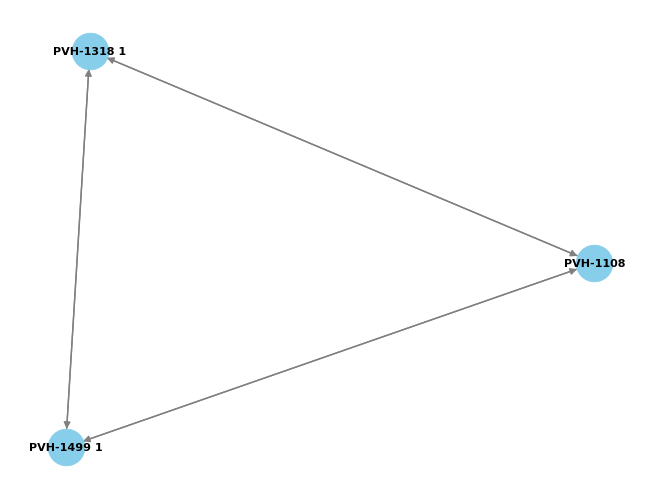

In [15]:
#%%
# Remove all connections (edges) from the graph
G.clear_edges()
# Connect nodes within 200 meters
for node_i, data_i in G.nodes(data=True):
    for node_j, data_j in G.nodes(data=True):
        if node_i != node_j:  # Avoid self-loops
            distance = calculate_distance(data_i['latitude'], data_i['longitude'],
                                          data_j['latitude'], data_j['longitude'])
            if distance < 4: #3
                G.add_edge(node_i, node_j)

# Draw the graph
plt.figure()
# pos = nx.get_node_attributes(G, 'pos')
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue',
        font_size=8, font_color='black', font_weight='bold',
        arrowsize=10, edge_color='gray', linewidths=0.5)

#plt.title('Grid Layout with Connections within 200m')
plt.show()

Identify Tops
Note: this seems to only work when current node "pozo" is 1318 1

In [16]:
ruta_archivo = ruta_logs +"/Capas O PVH-1318_PVH-1499.xls"

# Leer el archivo usando pandas
tops = pd.read_excel(ruta_archivo)
tops=tops[tops["Pozo"]=="PVH-1318"]
a = tops.loc[tops["Pozo"] == "PVH-1318", ["Pozo", "Capa", "Tope"]]
a.rename(columns={"Tope": "Ref"}, inplace=True)

b=tops.loc[tops["Pozo"] == "PVH-1318", ["Pozo", "Capa", "Base"]]
b.rename(columns={"Base": "Ref"}, inplace=True)
resultado = pd.concat([a, b], ignore_index=True)
tops=resultado
# Mostrar las primeras filas del DataFrame para verificar la lectura
print(tops.head(10))


plt.show()

G.nodes['PVH-1318 1']["tops"]=tops

       Pozo  Capa        Ref
0  PVH-1318   O4T  1600.6632
1  PVH-1318   O5T  1614.4039
2  PVH-1318  O5aT  1624.3099
3  PVH-1318  O5bT  1630.0619
4  PVH-1318   O7T  1639.0092
5  PVH-1318   O4T  1610.2498
6  PVH-1318   O5T  1619.7299
7  PVH-1318  O5aT  1626.8663
8  PVH-1318  O5bT  1633.5769
9  PVH-1318   O7T  1642.5242


Finally using DTW Algorithm, can start from here.

In [17]:

# only works when this is current node, need to make this more universal
pozo='PVH-1318 1'

def normalize_array(arr):
    reshaped_arr = arr.reshape(-1, 1)
    scaler = MinMaxScaler()
    normalized_arr = scaler.fit_transform(reshaped_arr)
    return normalized_arr

def custom_distance(p1, p2):
    return np.abs(p1 - p2) **(1/ 4.1)


For real the block of code i want to test. This block is the main algorithm

In [18]:
def calc_tops(G, node1, node2):
    
    correla, df1, df2 = dtw_calc(G, node1, node2)

    # create a list of j values for unique i values
    df_result = pd.DataFrame(columns=["Capa",'Ref'])
    j_values_dict = {}
    for i, j in correla:
        
        if i not in j_values_dict:
            j_values_dict[i] = []
        j_values_dict[i].append(j)

    rows_to_add = []
    # obtaining a 1 to 1 relationship between i and j by averaging 
    for i, j_values in j_values_dict.items():
        i_depth = df1["DEPTH"].iloc[i]
        j_depths = [df2["DEPTH"].iloc[j] for j in j_values]
        # averaging j values
        j_depth = np.mean(j_depths)
        #print(f'i = {i_depth}, j = {j_depth}')
        rows_to_add.append({'Ref': j_depth})
    capas = ["O4T", "O4T", "O5T", "O5T", "O5aT", "O5aT", "O5bT", "O5bT", "O7T", "O7T", ]
    df_result = pd.concat([df_result, pd.DataFrame(rows_to_add)], ignore_index=True)
    df_result["Capa"] = capas

    # assign new top values to the node
    G.nodes[node2]["tops"]=df_result
    print(G.nodes[node2]["tops"])


def dtw_calc(G, node1, node2):
    tolerance = 0.05
    df1 = G.nodes[node1]["data"] # RES_DEEP data for node1
    tops = G.nodes[node1]["tops"] # Tops data for node1

    df2 = G.nodes[node2]["data"] # RES_DEEP data for node2



    # mark rows within the tolerance range of any top
    for index_df1, row_df1 in df1.iterrows():
        depth_value = row_df1['DEPTH']
        matches = tops['Ref'].apply(lambda x: np.abs(x - depth_value) <= tolerance)
        if matches.any():
            df1.at[index_df1, 'Present'] = 1

    G.nodes[node1]["is_top"] = df1[df1['Present'] == 1] # store the filtered rows near the topes into the graph
    prof1 = df1[df1['Present'] == 1]["DEPTH"].reset_index()["DEPTH"][0] - 50
    prof2 = df1[df1['Present'] == 1]["DEPTH"].reset_index()["DEPTH"].iloc[-1] + 50
    df1 = df1[(df1['DEPTH'] > prof1) & (df1['DEPTH'] < prof2)].reset_index()
    df2 = df2[(df2['DEPTH'] > prof1) & (df2['DEPTH'] < prof2)].reset_index()


    # normalize res deep in df1 and df2
    w1 = np.array(df1['RES_DEEP'].dropna())
    w2 = np.array(df2['RES_DEEP'].dropna())
    # might need to use normalized values later, not rn tho
    w1_normalized = normalize_array(w1)
    w2_normalized = normalize_array(w2)


    ref = df1[df1["Present"] == 1]
    distance, path = fastdtw(w1, w2, dist=custom_distance)
    # distance, path = fastdtw(w1_normalized, w2_normalized, dist=custom_distance) Might need to normalize later
    correla = [tupla for tupla in path if tupla[0] in ref.index]

    #mark tops in df2, this block of code is not necessary
    # correla2 = [tupla[1] for tupla in correla]
    # df2["is_top"] = 0
    # for elemento in correla2:
    #     if elemento in df2.index:
    #         df2.loc[elemento, "is_top"] = 1
    # G.nodes[node2]["is_top"] = df2[df2["is_top"] == 1]
    # G.nodes[node2]["Procesados"] = df2
    
    return correla, df1, df2


def profiles_comparison(G, node1, node2):
    correla, df1, df2 = dtw_calc(G, node1, node2)

    offset = 50
    plt.figure(figsize=(10, 6))

    # Plot df1
    plt.plot(df1["DEPTH"], df1["RES_DEEP"], label=node1, color='blue')

    # Plot df2 with offset
    plt.plot(df2["DEPTH"], df2["RES_DEEP"] + offset, label=node2, color='orange')

    for i, j in correla:
        # Plot the DTW path
        plt.plot([df1["DEPTH"].iloc[i], df2["DEPTH"].iloc[j]], [df1["RES_DEEP"].iloc[i], df2["RES_DEEP"].iloc[j] + offset], color='red', linestyle='-')

    plt.title(node2 + " " + node1)
    plt.xlabel('Depth (m)')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.show()

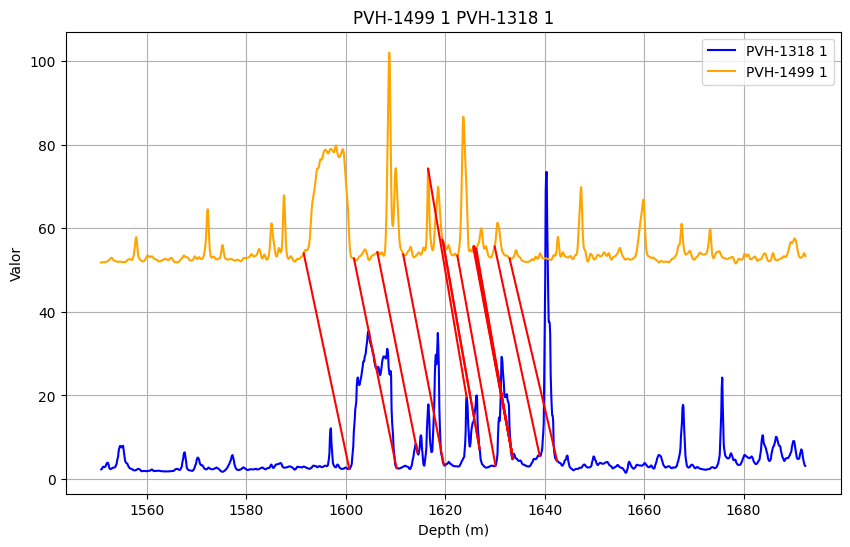

In [19]:
profiles_comparison(G, "PVH-1318 1", "PVH-1499 1")

In [20]:
calc_tops(G, "PVH-1318 1", "PVH-1499 1")
calc_tops(G, "PVH-1499 1", "PVH-1108")
calc_tops(G, "PVH-1108", "PVH-1318 1")

C:\Users\User\AppData\Local\Temp\ipykernel_24344\1880345703.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_result = pd.concat([df_result, pd.DataFrame(rows_to_add)], ignore_index=True)


   Capa        Ref
0   O4T  1591.5332
1   O4T  1601.6332
2   O5T  1606.3332
3   O5T  1611.5332
4  O5aT  1616.5332
5  O5aT  1619.4832
6  O5bT  1622.4332
7  O5bT  1625.9332
8   O7T  1629.9332
9   O7T  1632.9332


C:\Users\User\AppData\Local\Temp\ipykernel_24344\1880345703.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_result = pd.concat([df_result, pd.DataFrame(rows_to_add)], ignore_index=True)


   Capa        Ref
0   O4T  1590.5776
1   O4T  1600.6776
2   O5T  1609.2776
3   O5T  1618.4776
4  O5aT  1623.2776
5  O5aT  1627.7776
6  O5bT  1630.1776
7  O5bT  1633.9776
8   O7T  1638.2776
9   O7T  1640.2776
   Capa     Ref
0   O4T  1583.5
1   O4T  1592.2
2   O5T  1600.0
3   O5T  1610.1
4  O5aT  1614.2
5  O5aT  1618.4
6  O5bT  1620.7
7  O5bT  1624.2
8   O7T  1628.1
9   O7T  1630.1


C:\Users\User\AppData\Local\Temp\ipykernel_24344\1880345703.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_result = pd.concat([df_result, pd.DataFrame(rows_to_add)], ignore_index=True)


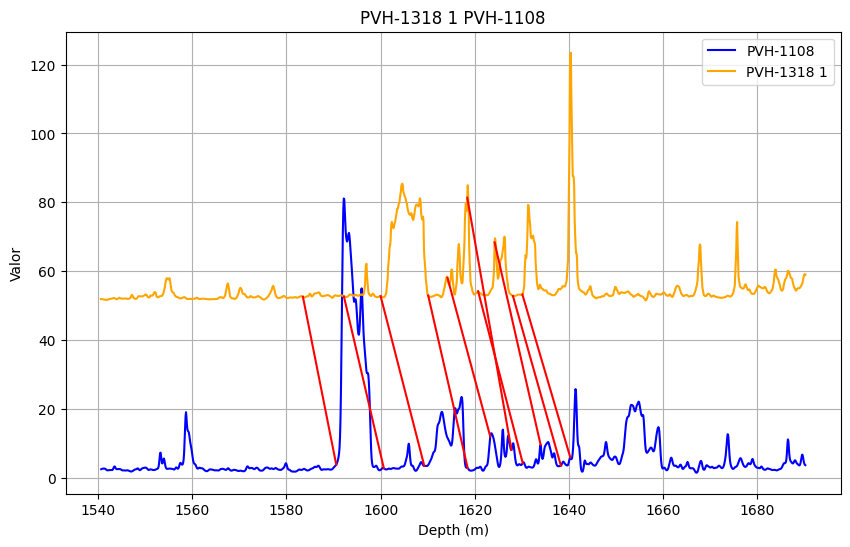

In [21]:
profiles_comparison(G, "PVH-1108", "PVH-1318 1")
